# **CeADAR Data Scientist Challenge**
---

## Proposed pipeline

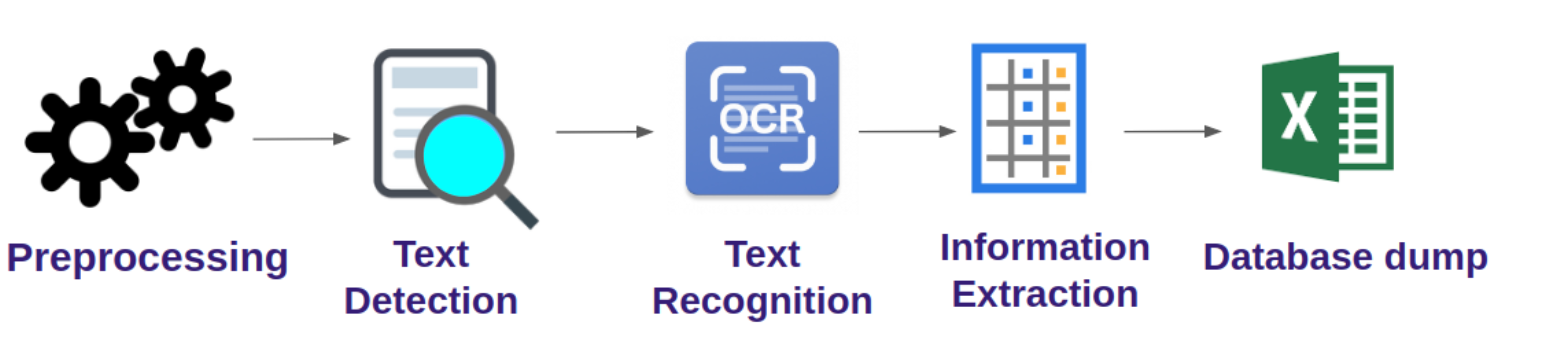

## Stages

### **1) Preprocessing**
*   **Alpha channel removal (if present)**: We will use only RGB channels
*   **Receipt recognition**: I decided to use a deep learning model for this purpose. Our images are very different, sometimes very noisy so a manual strategy like looking for contours in the raw image will be too expensive at the moment of fine tuning. So, in order to obtain the position of the receipts in the image I will use Mask R-CNN Inception ResNet V2 for instance segmentation. Once obtained the mask for a receipt, it should be easier to find contours and isolate that portion of the image for a better preprocessing.

*   **Noise removal**
*   **Binarization**: Black text in a white background
*   **Skew correction**: We need to get the text as straight as posible and correct the image perspective.
*   **Text normalization**: Text in receipts can have different shapes and thickness, we need to make it as unifor as possible.


### **2) Text Detection:**
*   Tesseract is the weapon of choice for text detection. We will use it to see how good our prerocessing is performing.


### **3) Text Recognition:**
*   After getting a good rate of text detection we will be ready for text recognition (also using Tesseract). Tesseract is highly depensant on the qualiity of the images we use as input so a good preprocessing step is crucial.


### **4) Information Extraction:**
*   Just to keep it simple (at the moment) I will use a regular expression for parsing the "Total" of every receipt. I will consider that the highest float number in the text is the "Total". Of course this approach is kind of naive because there are some cases that will not be covered. But this could be easily improved with a more robust set of rules.


### **5)Postprocessing (Optional):**
*   We can perform a postprocessing in order to improve the parsed text.



---



## Environment setup

In [25]:
import os
import re
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import cv2
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen
from google.colab import drive

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/MyDrive/Documents/projects/ceadar_challenge/'

/content/drive/MyDrive/Documents/projects/ceadar_challenge


## Visualization tools

To visualize the images with the proper segmentation, we will use the TensorFlow Object Detection API. To install it we will clone the repo.

In [ ]:
# @title Install the Tensorflow Object Detection API
%%bash
rm -rf models
git clone --depth 1 https://github.com/tensorflow/models

apt update
apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


In [ ]:
# @title Install Tesseract OCR
%%bash
apt install -y tesseract-ocr
pip install pytesseract

In [5]:
# @title Import the dependencies we will need later
import pytesseract
from pytesseract import Output

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

## Build a detection model and load pre-trained model weights

**Note:** more details about Mask R-CNN Inception ResNet V2 1024x1024 model [Here](https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1)

In [7]:
#@title Loading model: Mask R-CNN Inception ResNet V2 1024x1024
model_handle = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

hub_model = hub.load(model_handle)
print('OK!')

OK!


## Pipeline manipulation functions

In [8]:
# @title Load and Transform Images Functions
def load_image(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
        path: the file path to the image

    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if (path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data)).convert('RGB')

    return image

def resize_image(image, baseheight=512):
    wpercent = (baseheight/float(image.size[1]))
    wsize = int((float(image.size[0])*float(wpercent)))
    image = image.resize((wsize, baseheight), Image.ANTIALIAS)
    return image


def image_into_numpy_array(image):
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (1, im_height, im_width, 3)).astype(np.uint8)

In [9]:
# @title Object Recognition Functions
def receipt_recognition(image_np):
    # running inference
    results = hub_model(image_np)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}

    # we need to convert np.arrays to tensors
    detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
    detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
                image_np.shape[1], image_np.shape[2])
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                        tf.uint8)
    result['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return result


In [10]:
# @title Find Contours Functions
def find_contours(mask):
    contours, hierarchy = cv2.findContours(
        mask, 
        cv2.RETR_TREE, 
        cv2.CHAIN_APPROX_SIMPLE)
    return contours

# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contour):    
    approx = approximate_contour(contour)
    # if our approximated contour has four points, we can assume it is receipt's rectangle
    if len(approx) == 4:
        return approx

def get_rectangle_receipt_contour(contours):
    largest_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]
    receipt_contour = get_receipt_contour(largest_contour)
    return receipt_contour

def contour_to_rect(contour, resize_ratio):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

def crop_and_perspective_correction(original_image, receipt_contour, baseheight):
    ratio = (baseheight / float(original_image.size[1]))
    cropped_receipt = wrap_perspective(
        np.array(original_image.copy()), 
        contour_to_rect(receipt_contour, 
        resize_ratio=ratio))
    return cropped_receipt

In [11]:
# @title Binarization Functions

from skimage.filters import threshold_local

def bw_scanner(image):
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

def binarize(cropped_receipt):
    result = bw_scanner(cropped_receipt)
    return result

In [12]:
# @title Text Extraction Functions
def get_total(text):
    float_list = list(map(lambda x: float(x), re.findall(r"[-+]?\d+\.\d\d(?!\d)", text)))
    if float_list:
        result = max(float_list)
    else:
        result = None
    return result

---

## Example with a single image

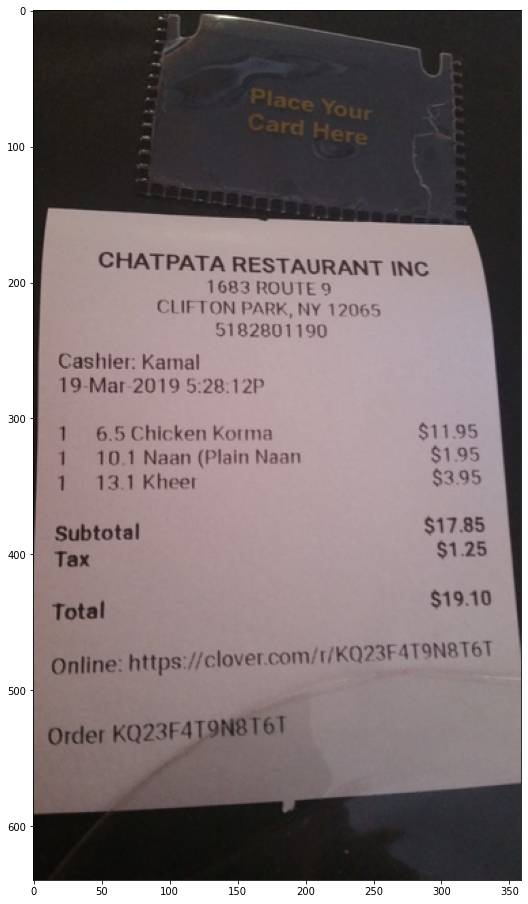

In [73]:
# @title Loading Image
image_path = 'raw_data/1125-receipt.jpg'

original_image = load_image(image_path)

baseheight = 640

image = resize_image(original_image.copy(), baseheight)

image_np = image_into_numpy_array(image)
# print(image_np.shape)

# Convert image to grayscale
convert_image_to_grayscale = 0
if(convert_image_to_grayscale):
    image_np[0] = np.tile(np.mean(image_np[0], 2, keepdims=True), 
                          (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(12,16))
plt.imshow(image_np[0])
plt.show()

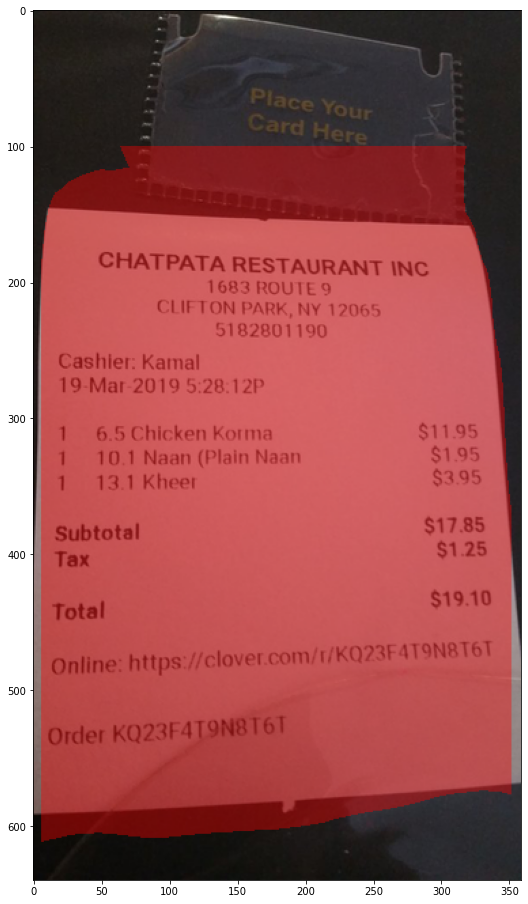

In [74]:
# @title Receipt recognition using Mask R-CNN Inception ResNet V2 for Instance Segmentation 
result = receipt_recognition(image_np)

class_value = 84
class_index = np.where(result['detection_classes'][0] == class_value)[0][0]

mask = image_np[0].copy()
viz_utils.draw_mask_on_image_array(mask, result['detection_masks_reframed'][class_index])
plt.figure(figsize=(12,16))
plt.imshow(mask)
plt.show()

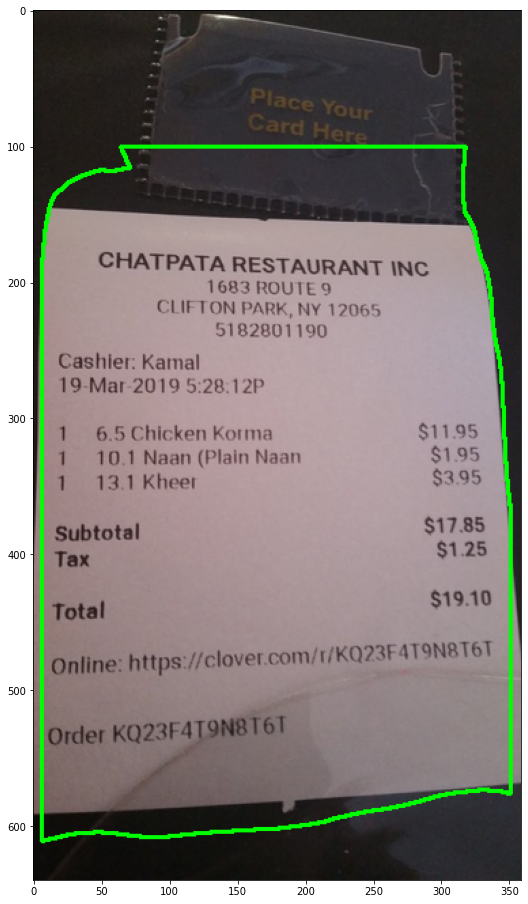

In [75]:
# @title Finding contours in the mask we infere before
contours = find_contours(result['detection_masks_reframed'][class_index])

image_with_contours = cv2.drawContours(
    image_np[0].copy(), 
    contours, 
    -1, 
    (0,255,0), 
    2)

plt.figure(figsize=(12,16))
plt.imshow(image_with_contours)
plt.show()

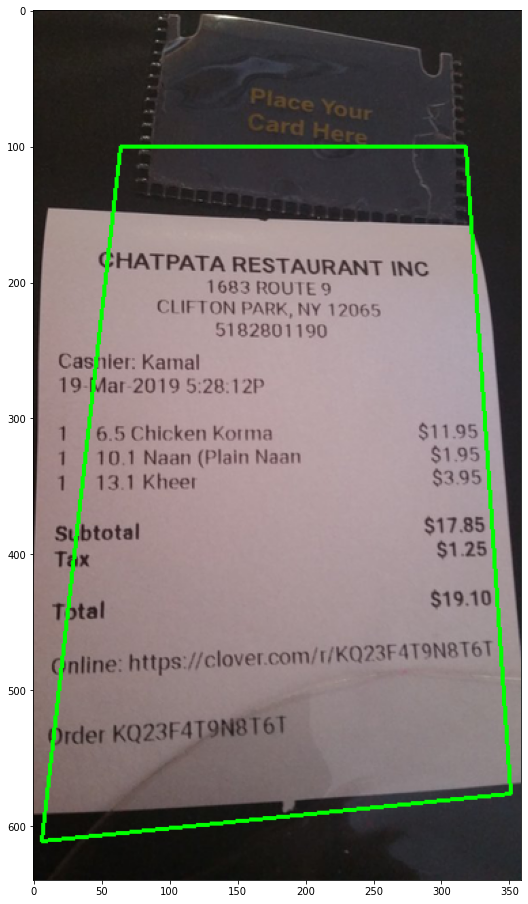

In [76]:
# @title Finding a "rectangle-shaped" area that fits the contour we compute
receipt_contour = get_rectangle_receipt_contour(contours)

image_with_receipt_contour = cv2.drawContours(
    image_np[0].copy(), 
    [receipt_contour], 
    -1, 
    (0, 255, 0),
    2)

plt.figure(figsize=(12,16))
plt.imshow(image_with_receipt_contour)
plt.show()

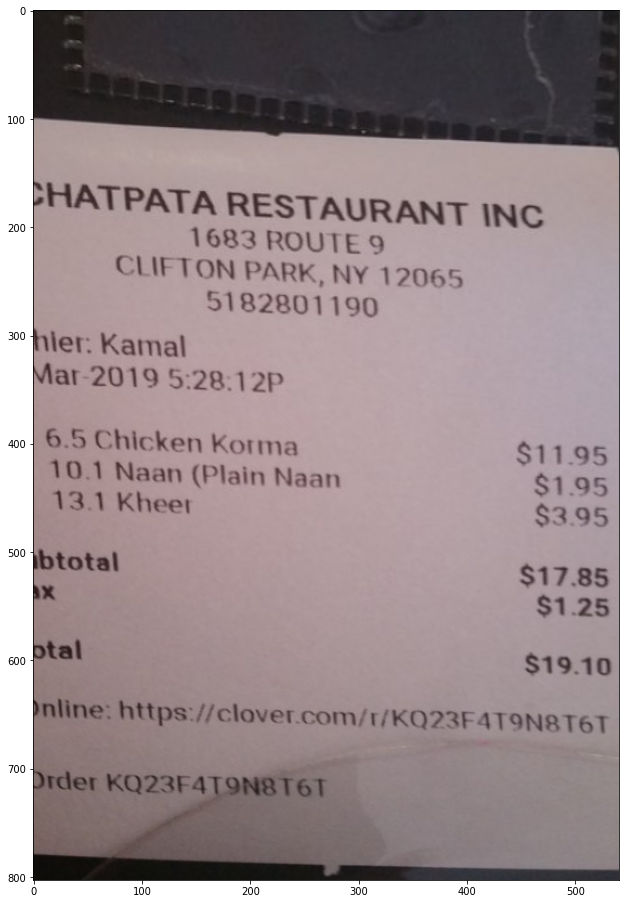

In [77]:
# @title Now, lets crop the image and correct the perspective a bit
scanned = crop_and_perspective_correction(original_image, receipt_contour, baseheight)

plt.figure(figsize=(12,16))
plt.imshow(scanned)
plt.show()

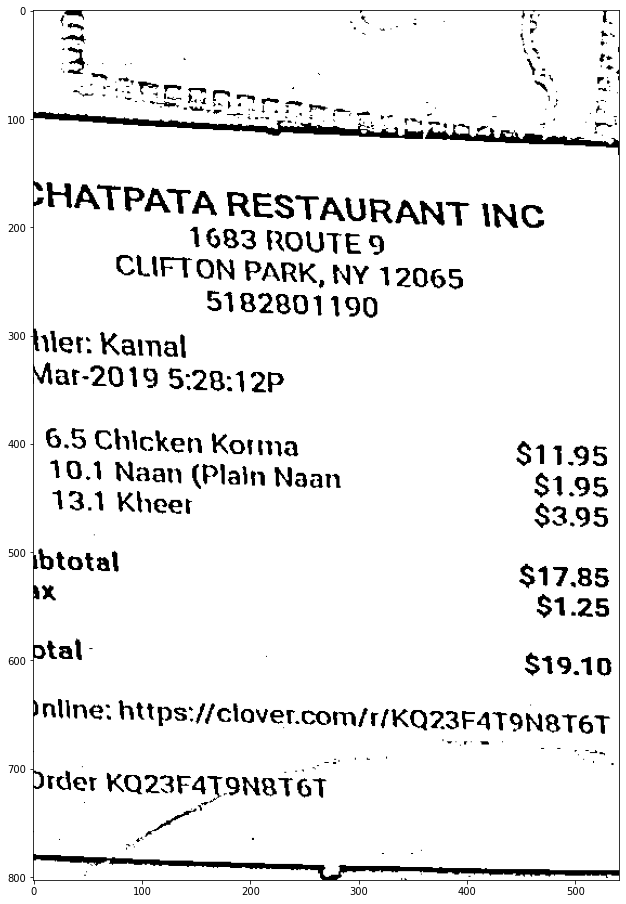

In [78]:
# @title Binarizing the image
result = binarize(scanned)

plt.figure(figsize=(12,16))
plt.imshow(result, cmap='Greys_r')
plt.show()

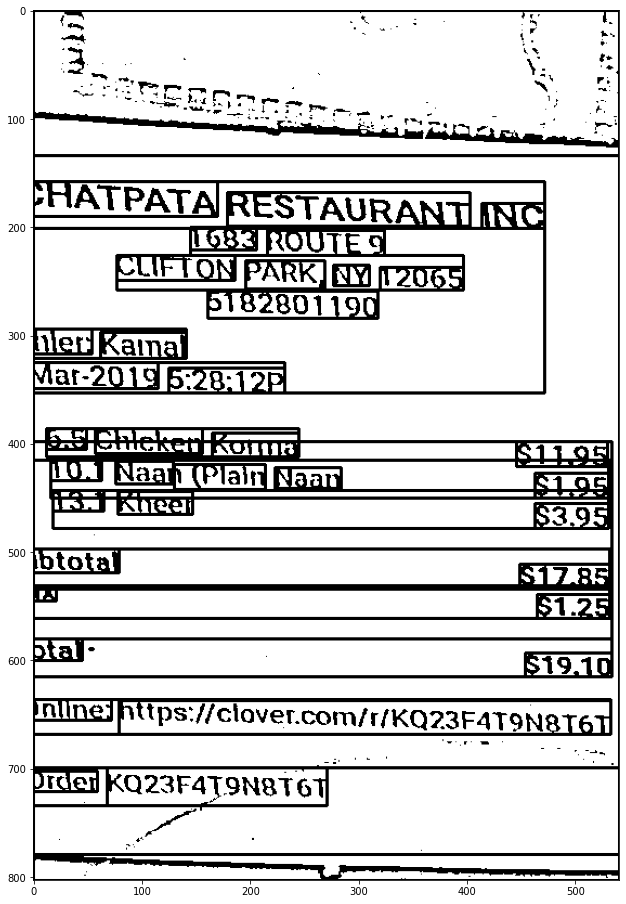

In [79]:
# @title Text Detection with Tesseract
img = result.copy()
d = pytesseract.image_to_data(img, output_type=Output.DICT)
n_boxes = len(d['level'])
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(12,16))
plt.imshow(img, cmap='Greys_r')
plt.show()

In [80]:
# @title Text Extraction witn Tesseract and Regular Expresions
text = pytesseract.image_to_string(result, lang='eng')
# print(text)
print('PREDICTED TOTAL: {}'.format(get_total(text)))

PREDICTED TOTAL: 19.1


---

In [23]:
import calendar
import time

def create_result_csv(pics_folder):
    d = {'receipt': {}, 'prediction': {}}
    list_of_receipt_pics = list(map(lambda x: x.split('.')[0], sorted(os.listdir(pics_folder))))
    for receipt_pic in list_of_receipt_pics:
        d['receipt'].append(receipt_pic)
        d['prediction'].append(None)

    df = pd.DataFrame(d)    
    df.to_csv('output/output_{}.csv'.format(calendar.timegm(time.gmtime())), index=False)

def load_result_csv():
    csv_folder = 'output'
    latest_csv = sorted(os.listdir(csv_folder), reverse=True)[0]
    df = pd.read_csv(''.join(os.path.join(csv_folder, latest_csv)))
    return df.to_dict()

def save_result_csv(predictions, receipt_pic):
    df = pd.DataFrame(predictions.items(), columns=['receipt', 'prediction'])
    df.to_csv('output/output_{}.csv'.format(receipt_pic), index=False)


In [ ]:
from IPython.display import clear_output

def show_receipt(img):
    plt.figure(figsize=(7,10))
    plt.imshow(img)
    plt.show()


pics_folder = 'raw_data/'
list_of_receipt_pics = list(map(lambda x: x.split('.')[0], sorted(os.listdir(pics_folder))))

# if results_csv not exists:
#     create_result_csv()

# # predictions : {receipt_pic : value, }
# predictions = load_result_csv()
predictions = {}
for receipt_pic in list_of_receipt_pics[158:]:

    # Load Image
    image_path = ''.join(os.path.join(pics_folder, '{}.jpg'.format(receipt_pic)))
    print(image_path)
    original_image = load_image(image_path)

    # show_receipt(original_image)

    baseheight = 640
    class_value = 84
    image = resize_image(original_image.copy(), baseheight)
    image_np = image_into_numpy_array(image)


    # Preprocessing Stage
    # Convert image to grayscale
    convert_image_to_grayscale = 0
    if(convert_image_to_grayscale):
        image_np[0] = np.tile(np.mean(image_np[0], 2, keepdims=True), 
                            (1, 1, 3)).astype(np.uint8)

    try:
        objects = receipt_recognition(image_np)
        class_index = np.where(objects['detection_classes'][0] == class_value)[0][0]
        receipt_mask = objects['detection_masks_reframed'][class_index]

        contours = find_contours(receipt_mask)
        receipt_location = get_rectangle_receipt_contour(contours)

        receipt = crop_and_perspective_correction(original_image, receipt_location, baseheight)
        receipt = binarize(receipt)


        # Text Detection and Recognition Stages
        text = pytesseract.image_to_string(receipt, lang='eng')


        # Information Extraction Stage
        predictions[receipt_pic] = get_total(text)
    except:
        print('Error with file: {}'.format(receipt_pic))
        predictions[receipt_pic] = None

    print(predictions[receipt_pic])

    # Dump Data
    save_result_csv(predictions, receipt_pic)

print(predictions)


---

During the stage of predicting values for all 200 images in the test dataset I found a bug that broke the pipeline for 9 images (when computing a rectangle-shaped from contours) so for computing metrics, these 9 entries won't be part of the calculation.


Images: 
* 1002-receipt 
* 1024-receipt 
* 1046-receipt 
* 1058-receipt 
* 1111-receipt 
* 1117-receipt 
* 1126-receipt 
* 1142-receipt 
* 1161-receipt

## Metrics
 - Precision
 - Levenshtein edit-distance

In [57]:
from nltk.metrics.distance import edit_distance

def precision(y_test, y_pred):
    n = len(y_test)
    prec = sum([1 if t == p else 0 for t, p in zip(y_test, y_pred)])
    return prec / n

def mean_levenshtein_distance(y_test, y_pred):
    n = len(y_test)
    dist = sum([edit_distance(s1, s2) for s1, s2 in zip(y_test, y_pred)])
    return dist / n



exceptions = [
              '1002-receipt',
              '1024-receipt',
              '1046-receipt',
              '1058-receipt',
              '1111-receipt',
              '1117-receipt',
              '1126-receipt',
              '1142-receipt',
              '1161-receipt']

df = pd.read_csv('output/data_dump.csv')
df = df[~df['receipt'].isin(exceptions)]
df.predicted = df.predicted.fillna(0)

df.predicted = df.predicted.astype(str)
df.total = df.total.astype(str)

print('Precision: {}'.format(precision(df.total, df.predicted)))
print('Mean Levenshtein Distance: {}'.format(mean_levenshtein_distance(df.total, df.predicted)))

Precision: 0.35602094240837695
Mean Levenshtein Distance: 2.1256544502617802


Both metrics could be easily improved by creating a more robust set of Regular Expressions in order to improve the heuristic of the Information Extraction stage. For instance, in the following example, the total value is 17.80 but the model predicted $20 because assumes that the largest float is the Total value. This could be improved adding a set of rules with words like: Total, Balance Due, etc

Also, working more thoroughsly in the stage of noise filtering and skew correction will improve even more the prediction quality of our model.

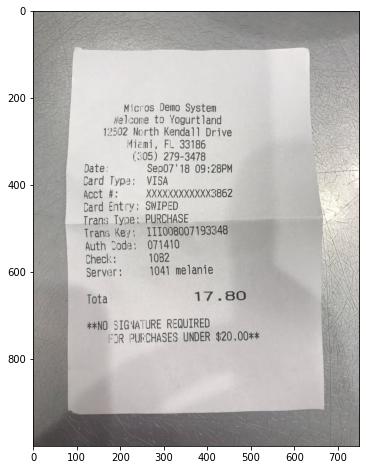

In [62]:
image = load_image('raw_data/1038-receipt.jpg')

plt.figure(figsize=(6,8))
plt.imshow(image)
plt.show()